# Analysis of DR9 QSO

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from tqdm.notebook import tqdm

import modules as md
import sys
sys.path.append('/Users/rezaie/github/LSSutils')
from lssutils.lab import (hpixsum, AnaFast, get_shotnoise,
                          make_overdensity, histogram_cell)

# n(z)

Text(0, 0.5, 'n(z)')

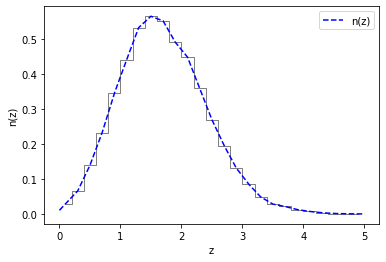

In [5]:
nz = md.NoZ('/Volumes/TimeMachine/data/DR9fnl/FOR_MEDHI/RF_g.txt')
z_g = np.arange(0.0, 5.0, 0.01)
np.savetxt('/Volumes/TimeMachine/data/DR9fnl/nz_qso_rf.txt',
          np.column_stack([z_g, nz.nz_fn(z_g)]),
          header='z -- n(z)')


plt.step(nz.z_, nz.nz_/nz.nz_norm, where='mid', lw=1, color='grey')
plt.plot(z_g, nz.nz_fn(z_g), 'b--', label='n(z)')
plt.legend()
plt.xlabel('z')
plt.ylabel('n(z)')

# Mask, Galaxy, and Randoms

In [35]:
# data
g = np.loadtxt('/Volumes/TimeMachine/data/DR9fnl/FOR_MEDHI/Catalogs/north_targets-final.txt')
gc = np.loadtxt('/Volumes/TimeMachine/data/DR9fnl/FOR_MEDHI/Catalogs/north_targets-final_corrected.txt')

# randoms
r = np.loadtxt('/Volumes/TimeMachine/data/DR9fnl/FOR_MEDHI/Catalogs/north_randoms.txt')

In [36]:
hp_r = hpixsum(256, r[:, 0], r[:, 1], weights=r[:, -1])
hp_r512 = hpixsum(512, r[:, 0], r[:, 1], weights=r[:, -1])

hp_g = hpixsum(256, g[:, 0], g[:, 1], weights=g[:, -1])
hp_gc = hpixsum(256, gc[:, 0], gc[:, 1], weights=gc[:, -1])

mask = hp_r > 0.0

In [37]:
frac = hp_r / hp_r[mask].mean()
get_shotnoise(hp_gc, frac, mask)

1.0173709503964513e-06

In [38]:
np.percentile(hp_gc[mask], [0, 1, 99, 100])

array([ 0.        ,  6.17444922, 26.9184522 , 69.38908296])

/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


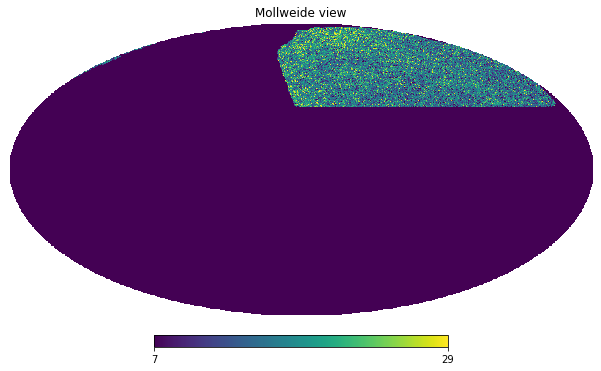

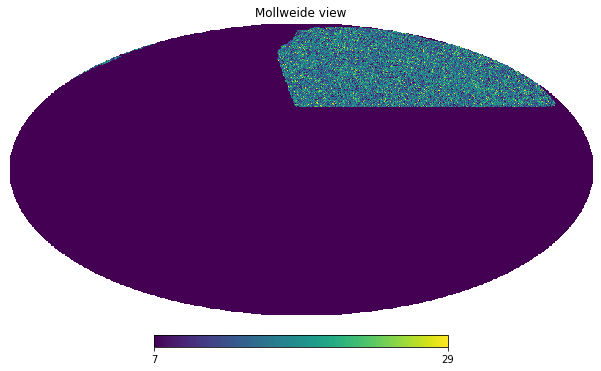

In [39]:
hp.mollview(hp_g, rot=-85, min=7, max=29)
hp.mollview(hp_gc, rot=-85, min=7, max=29)

In [40]:
delta = make_overdensity(hp_g, hp_r, mask)
delta_c = make_overdensity(hp_gc, hp_r, mask)

In [41]:
af = AnaFast()
cl = af.run(delta, hp_r, mask)
cl_c = af.run(delta_c, hp_r, mask)

/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  # This is added back by InteractiveShellApp.init_path()


(2e-07, 0.004162121152739425)

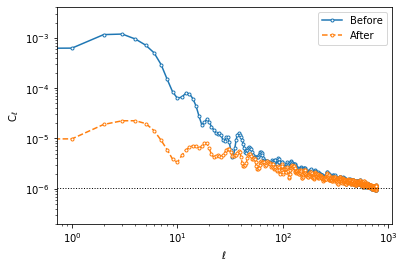

In [48]:
plt.plot(cl, marker='.', mfc='w')
plt.plot(cl_c, marker='.', mfc='w', ls='--')
plt.legend(['Before', 'After'])

plt.axhline(1.0173709503964513e-06, lw=1, color='k', ls=':')

plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'C$_{\ell}$')
plt.ylim(2.0e-7, 2.0-3)

In [49]:
np.savez('/Volumes/TimeMachine/data/DR9fnl/cl_qso_north_rf.npz', **{'cl_before':cl, 'cl_after':cl_c})
hp.write_map('/Volumes/TimeMachine/data/DR9fnl/north_mask_hp256.hp.fits', 
             hp_r, dtype='float64', fits_IDL=False, overwrite=True)
hp.write_map('/Volumes/TimeMachine/data/DR9fnl/north_mask_hp512.hp.fits', 
             hp_r512, dtype='float64', fits_IDL=False, overwrite=True)

# Create Gaussian Mocks

In [22]:
cl_data = np.load('/Volumes/TimeMachine/data/DR9fnl/cl_qso_north_rf.npz', allow_pickle=True)
shotnoise = 1.017379567874895e-06
cl_obs = cl_data['cl_after']#-shotnoise
el_obs = np.arange(cl_obs.size)
#elb, clb = histogram_cell(cl_obs, bins=np.arange(0, 700, 40.))

In [32]:
z, nz = np.loadtxt('/Volumes/TimeMachine/data/DR9fnl/nz_qso_rf.txt').T   # ext=0
b = 2.5*np.ones_like(z)

In [33]:
ell = np.arange(5000)

cosmo = md.init_cosmology()
mod = md.PNGModel(cosmo, has_rsd=True, has_fnl=True)
mod.add_tracer(z, b, nz, p=1.6)

cl_true = mod(ell, fnl=0.0)

np.savetxt('/Volumes/TimeMachine/data/DR9fnl/cl_true_fnl0.txt', cl_true)

NOTE: This code uses a cosmology calculator that returns k and P(k) in units of 1/Mpc and Mpc^3.
 Therefore, the coefficient alpha in the model uses H_0 = 100h, not H_0=100.
will create windows


Text(0, 0.5, 'C$_{\\ell}$')

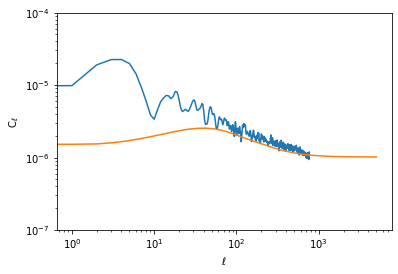

In [36]:
plt.plot(el_obs, cl_obs)
plt.plot(ell, cl_true+shotnoise)
plt.loglog()
plt.ylim(1.0e-7, 1.0e-4)
# plt.xlim(100, 650)
plt.xlabel(r'$\ell$')
plt.ylabel(r'C$_{\ell}$')

# Create Mock Realizations

In [37]:
# read c_ell
cl_true = np.loadtxt('/Volumes/TimeMachine/data/DR9fnl/cl_true_fnl0.txt')

# read mask
mask = hp.read_map('/Volumes/TimeMachine/data/DR9fnl/north_mask_hp256.hp.fits', dtype=np.float64) > 0.0
maskf = np.ones_like(mask)
weight = maskf * 1.0                 # all sky is the same

/Users/rezaie/anaconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/Users/rezaie/anaconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 256
  warnings.warn("NSIDE = {0:d}".format(nside))
/Users/rezaie/anaconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/Users/rezaie/anaconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


In [38]:
# run once
cls = {'full':[], 'masked':[]}

nside = 256
nmocks = 2000

np.random.seed(42)
seeds = np.random.randint(0, 2**32-1, size=nmocks)

print(np.unique(seeds).size)
af = md.AnaFast()

i = 0
for seed in tqdm(seeds):
    
    np.random.seed(seed)
    map1 = hp.synfast(cl_true, nside, pol=False, )
    
    map_f = map1 - map1.mean()       # full sky
    map_p = map1 - map1[mask].mean()  # partial sky
    
    
    filename = f'/Volumes/TimeMachine/data/DR9fnl/gaussian_mocks/mock_{i:04d}.fits'
    #print(filename, map_f[maskf].mean(), map_p[mask].mean())

    hp.write_map(filename, map1, fits_IDL=False, overwrite=True, dtype='float64')
    
    cls['full'].append(af.run(map_f, weight, maskf))
    cls['masked'].append(af.run(map_p, weight, mask))
    
    i += 1
np.savez('./cl_mocks_2k_qso.npz', **cls)    

2000


  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/rezaie/anaconda3/envs/sysnet/lib/python3.8/site-packages/healpy/sphtfunc.py:433: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  warnings.warn(
/Users/rezaie/anaconda3/envs/sysnet/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/Users/rezaie/anaconda3/envs/sysnet/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


In [15]:
cl_data = np.load('/Volumes/TimeMachine/data/DR9fnl/cl_qso_north_rf.npz', allow_pickle=True)
shotnoise = 1.017379567874895e-06

In [16]:
cl_obs = cl_data['cl_after']-shotnoise
el_obs = np.arange(cl_obs.size)
elb, clb = histogram_cell(cl_obs, bins=np.arange(0, 700, 40.))

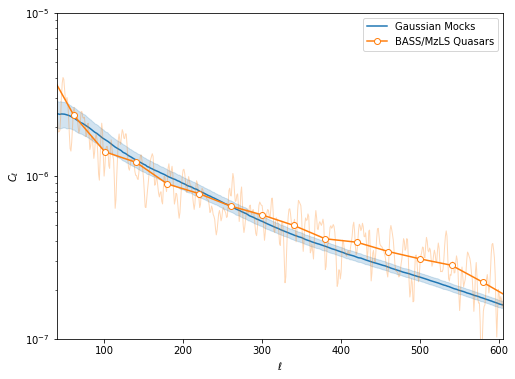

In [26]:
cl_mean = np.mean(cls['masked'], axis=0)
cl_min, cl_max = np.percentile(cls['masked'], [15.4, 84.6], axis=0)
el = np.arange(cl_min.size)


plt.figure(figsize=(8, 6))

# mocks
plt.plot(el, cl_mean, color='C0', label='Gaussian Mocks')
plt.fill_between(el, cl_min, cl_max, color='C0', alpha=0.2)

# plt.plot(cl_true, 'r--', zorder=5, label='Truth')

plt.plot(el_obs, cl_obs, color='C1', alpha=0.3, lw=1)
plt.plot(elb, clb, color='C1', marker='o', mfc='w', ls='-', label='BASS/MzLS Quasars')

plt.legend()
plt.xlim(40, 605)
plt.ylim(1.0e-7, 1.0e-5)
plt.yscale('log')

plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
# plt.xscale('log')
# plt.yscale('log')
plt.savefig('mocks_vs_data.png', dpi=300, bbox_inches='tight')